In [1]:
import sqlalchemy
from os import environ

import numpy as np
import pandas as pd

from jupyter_dash import JupyterDash
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
from dash import dcc

from sklearn.cluster import KMeans

## The ESPN fantasy league assigns value to some recorded player statistics. The values include:

- Points scored PTS = 1
- Blocks BLK = 4
- Assists AST = 2
- Rebounds REB = 1
- Field goals made FGM = 2
- Free throws made FTM = 1
- Three pointers made PM3 = 1
- Steals STL = 4

## Some values result in a penalty (negative scores):

- Turnovers TOV = -2
- Field goals attempted FGA = -1
- Free throws attempted FTA = -1

In [2]:
value = {"PTS":1,"BLK":4,"AST":2,"TOV":-2,"FGM":2,"FGA":-1,"FTM":1,"FTA":-1,"PM3":1,"STL":4,"REB":1}

### The fantasy scores are given as :
$$score = \sum^{N-1}_{i=0} v_i \cdot s_i$$

Where $v_i$ is the value assigned to stat $s_i$.

In [3]:
v = np.array(list(value.values()))

In [4]:
stats = ", ".join([k.lower() for k in list(value.keys()) if k != 'REB'])

In [5]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://"+environ.get("USER")+\
                                  ":"+environ.get("PSWD")+"@127.0.0.1:3306/nba")

In [6]:
fields = "name, game_day, substring(game_id,1,5) as season_id, " + stats + ", (oreb + dreb) as reb " 

join =  'box_scores INNER JOIN players on box_scores.player_id = players.id '

select = "SELECT "+ fields + "FROM " + join 
select += ' ORDER BY name, game_day;'

In [7]:
box_scores = pd.read_sql(select,engine,parse_dates=["game_day"])

In [8]:
box_scores.head()

,name,game_day,season_id,pts,blk,ast,tov,fgm,fga,ftm,fta,pm3,stl,reb
0,Aaron Brooks,2012-10-31,00212,7,0,1,0,3,10,0,1,1,1,3
1,Aaron Brooks,2012-11-02,00212,0,0,1,0,0,5,0,0,0,0,0
2,Aaron Brooks,2012-11-03,00212,11,1,2,2,4,11,0,0,3,1,5
3,Aaron Brooks,2012-11-05,00212,12,0,2,2,5,8,1,2,1,0,0
4,Aaron Brooks,2012-11-07,00212,11,0,4,0,5,12,0,0,1,1,2


#### Calculate the fantasy points by a matrix multiplication
$$\vec{f} = \vec{v} \times \matrix{B} $$

Where $\vec{f}$ is all player's fantasy points, $\vec{v}$ is the values assigned to the all player's box scores $\matrix{B}$.

In [9]:
def calc_fantasy_points(v, box_scores):
    return v @ box_scores

In [10]:
s = np.array(box_scores.values[:,3:],dtype = np.int64)

In [11]:
box_scores["Fantasy Points"] = calc_fantasy_points(v, s.T)

## The fantasy scores can then be grouped by the player names and aggregated using a rolling mean on their fantasy scores.

Typically, there are 3-4 games a week and since the Fantasy League is in a week-by week format, it makes sense to set the rolling mean window to 4. This will show how a player is doing on a week to week basis.

In [12]:
names = box_scores["name"].unique()

In [13]:
rolls = box_scores[['name','season_id','Fantasy Points']]
rolls= rolls.groupby(["name",'season_id'],as_index=False).rolling(4,min_periods =1).mean()

In [14]:
fps = box_scores.groupby(["name",'season_id'],as_index=False).mean()

In [15]:
box_scores["Rolling"] = rolls["Fantasy Points"]

In [16]:
box_scores.head()

,name,game_day,season_id,pts,blk,ast,tov,fgm,fga,ftm,fta,pm3,stl,reb,Fantasy Points,Rolling
0,Aaron Brooks,2012-10-31,00212,7,0,1,0,3,10,0,1,1,1,3,12,12.00
1,Aaron Brooks,2012-11-02,00212,0,0,1,0,0,5,0,0,0,0,0,-3,4.50
2,Aaron Brooks,2012-11-03,00212,11,1,2,2,4,11,0,0,3,1,5,24,11.00
3,Aaron Brooks,2012-11-05,00212,12,0,2,2,5,8,1,2,1,0,0,14,11.75
4,Aaron Brooks,2012-11-07,00212,11,0,4,0,5,12,0,0,1,1,2,24,14.75


In [17]:
box_scores.groupby(['name','season_id']).mean()#.sort_index(level=[0,1])

pts       blk       ast       tov        fgm  \
name            season_id                                                       
AJ Hammons      00216       2.181818  0.590909  0.181818  0.454545   0.772727   
AJ Price        00211       3.909091  0.045455  1.954545  0.727273   1.340909   
                00212       7.736842  0.052632  3.596491  1.122807   2.824561   
                00213       1.571429  0.000000  0.464286  0.250000   0.678571   
                00214       5.115385  0.000000  1.769231  0.538462   1.961538   
...                              ...       ...       ...       ...        ...   
Zion Williamson 00219      22.500000  0.375000  2.083333  2.458333   8.750000   
                00220      27.000000  0.639344  3.704918  2.737705  10.393443   
Zoran Dragic    00214       1.750000  0.000000  0.312500  0.312500   0.687500   
Zylan Cheatham  00219       3.000000  0.250000  0.750000  1.000000   1.500000   
                00221       0.000000  0.000000  0.000000  0.000000   0.000000   

                                 fga       ftm       fta       pm3       stl  \
name            season_id                                                      
AJ Hammons      00216       1.909091  0.409091  0.909091  0.227273  0.045455   
AJ Price        00211       3.954545  0.636364  0.795455  0.590909  0.454545   
                00212       7.245614  0.859649  1.087719  1.228070  0.578947   
                00213       1.642857  0.000000  0.071429  0.214286  0.035714   
                00214       5.269231  0.615385  0.923077  0.576923  0.269231   
...                              ...       ...       ...       ...       ...   
Zion Williamson 00219      15.000000  4.750000  7.416667  0.250000  0.666667   
                00220      17.000000  6.049180  8.672131  0.163934  0.934426   
Zoran Dragic    00214       1.875000  0.187500  0.312500  0.187500  0.125000   
Zylan Cheatham  00219       2.250000  0.000000  0.000000  0.000000  0.250000   
                00221       3.000000  0.000000  0.000000  0.000000  0.000000   

                                reb  Fantasy Points    Rolling  
name            season_id                                       
AJ Hammons      00216      1.636364        5.181818   4.708333  
AJ Price        00211      1.386364        8.909091   8.655303  
                00212      2.000000       16.614035  16.358187  
                00213      0.357143        2.357143   2.190476  
                00214      1.230769        8.807692   9.208333  
...                             ...             ...        ...  
Zion Williamson 00219      6.250000       32.250000  32.208333  
                00220      7.229508       43.786885  43.394809  
Zoran Dragic    00214      0.500000        2.312500   0.614583  
Zylan Cheatham  00219      2.250000        7.500000   4.166667  
                00221      0.000000       -3.000000  -3.000000  

[7975 rows x 13 columns]

In [18]:
len(box_scores)

293686

In [19]:
def options(names):
    options = []
    for i in names:
        d = {}
        d["label"] = i
        d["value"] = i
        options.append(d)
        
    return options

## Below defines a dashboard that shows a line graph for aggregated fantasy scores against the game day. A searchable dropdown includes all the players who recorded stats this season. Simply search and select the player(s) of interest and their fantasy points over the course of the season will be visible. The dropdown includes functionality for multiple players to enable multiple comparisons. 

## A second graph, a (overlaid) histogram with the marginal plots for the fantasy points counts is included to show the distribution of fantasy points for the selected players.

In [20]:
def drpdwn(i):
    opts = options(names)
    d = dcc.Dropdown(options = opts, value = names[0:2],id = i,multi = True)
    
    return d

In [21]:
models = {}
cols = ['pts', 'blk', 'ast', 'tov', 'fgm',
    'fga', 'ftm', 'fta', 'pm3', 'stl', 'reb']

cost = []

for k in range(2,20):
    model = KMeans(k)
    model.fit(box_scores[cols])
    models[f'k_{k}'] = model
    cost.append(model.inertia_)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


In [ ]:
px.scatter(x=range(2,20),y=cost)

### Choose k=7

In [22]:
cols = ['pts', 'blk', 'ast', 'tov', 'fgm','fga', 'ftm', 'fta', 'pm3', 'stl', 'reb']

k = 7
model = KMeans(k)
model.fit(box_scores[cols])

KMeans(n_clusters=7)

In [23]:
box_scores['cluster'] = model.predict(box_scores[cols])

In [24]:
box_scores.groupby('cluster').mean().sort_values('Fantasy Points',ascending=False)

,pts,blk,ast,tov,fgm,fga,ftm,fta,pm3,stl,reb,Fantasy Points,Rolling
cluster,,,,,,,,,,,,,
5,33.388071,0.725794,5.279850,2.985615,11.692818,22.178931,7.082107,8.501051,2.920328,1.358747,7.426137,56.448932,45.763122
1,23.136533,0.640568,4.208965,2.314382,8.450056,16.750430,4.225551,5.249869,2.010870,1.176765,6.547404,41.878670,35.890288
6,13.025018,1.125139,2.238809,1.759341,4.899880,10.020579,2.767249,3.944506,0.458010,0.877451,10.820986,31.875231,28.826632
2,16.507749,0.449611,3.370859,1.755006,6.198319,12.783715,2.231295,2.806487,1.879816,1.027167,4.162773,30.726887,27.474137
3,10.367265,0.427451,2.409870,1.325236,3.903518,8.697255,1.426577,1.870734,1.133653,0.831292,3.619559,20.990336,20.698372
4,5.438282,0.447172,1.599207,1.018633,2.058243,5.351524,0.843973,1.207417,0.477822,0.619738,3.753713,13.500126,15.760098
0,1.268514,0.193905,0.657900,0.489186,0.466478,1.860815,0.234473,0.376973,0.101085,0.266046,1.402675,3.879142,7.966165


In [27]:
labs = {0:'horrible',4:'below average',3:'average',2:'good',6:'good',
        1:'great',5:'outstanding'}

In [28]:
box_scores['Rating'] = [labs[i] for i in box_scores['cluster']]

In [109]:
pivot = (box_scores[box_scores['game_day'].dt.year>2017]
.groupby(['name','season_id','Rating'],as_index=False)
.count()).iloc[:,:4]

In [110]:
pivot = pivot.pivot_table(index=['name','Rating'],columns = ['season_id'],values='game_day')

In [111]:
years = [int(i[-2:]) for i in pivot.columns]
weights = [1/(max(years) - y + 1) for y in years]

In [119]:
counts.join(pivot, on = ['name','Rating']).iloc[:,-10:].head()

,00217,00218,00219,00220,00221,00417,00418,00419,00420,00421
0,4.0,11.0,13.0,13.0,23.0,NaN,1.0,NaN,3.0,2.0
1,NaN,4.0,5.0,11.0,8.0,NaN,NaN,NaN,3.0,NaN
2,15.0,39.0,27.0,19.0,27.0,NaN,3.0,NaN,4.0,2.0
3,9.0,22.0,16.0,4.0,15.0,NaN,1.0,NaN,NaN,1.0
4,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
counts = (box_scores[box_scores['game_day'].dt.year>2017]
    .groupby(['name','Rating'],as_index=False)
    .count())#[['game_day']]
#.mean()#.sort_values('Fantasy Points',ascending=False)
totals = counts.groupby('name').sum()['game_day'].rename('totals')
counts = counts.join(totals, on='name')[['name','Rating','game_day','totals']]

In [157]:
counts['percentage'] = counts['game_day']/counts['totals']

counts['weighted_counts'] = (counts.join(pivot, on = ['name','Rating']).iloc[:,-10:]*weights).sum(axis=1)

In [158]:
counts = (counts
          .join(counts.groupby(['name']).sum()['weighted_counts'].rename('weighted_total'),
                on='name'))

counts['weighted_percentage'] = counts['weighted_counts']/counts['weighted_total']


In [160]:
order = [i if j!='good' else 3 for i,j in enumerate(labs.values())]

In [161]:
order = dict(zip(labs.values(),order))

In [162]:
order

{'horrible': 0,
 'below average': 1,
 'average': 2,
 'good': 3,
 'great': 5,
 'outstanding': 6}

In [163]:
counts['order'] = 100
for i in order:
    counts['order'].mask(counts['Rating']==i,order[i],inplace=True)

In [164]:
counts[counts['name']=='Jamal Murray'].sort_values('order')

,name,Rating,game_day,totals,percentage,weighted_counts,weighted_total,weighted_percentage,order
1703,Jamal Murray,horrible,1,260,0.003846,0.333333,81.25,0.004103,0
1700,Jamal Murray,below average,11,260,0.042308,3.266667,81.25,0.040205,1
1699,Jamal Murray,average,34,260,0.130769,10.150000,81.25,0.124923,2
1701,Jamal Murray,good,97,260,0.373077,28.483333,81.25,0.350564,3
1702,Jamal Murray,great,86,260,0.330769,28.116667,81.25,0.346051,5
1704,Jamal Murray,outstanding,31,260,0.119231,10.900000,81.25,0.134154,6


In [261]:
counts

,name,Rating,game_day,totals,percentage,weighted_counts,weighted_total,weighted_percentage,order,improvement
0,Aaron Brooks,average,1,20,0.050000,0.200000,4.000000,0.050000,2,0.0
1,Aaron Brooks,below average,4,20,0.200000,0.800000,4.000000,0.200000,1,0.0
2,Aaron Brooks,horrible,15,20,0.750000,3.000000,4.000000,0.750000,0,0.0
3,Aaron Gordon,average,70,315,0.222222,41.133333,157.416667,0.261302,2,3.9
4,Aaron Gordon,below average,31,315,0.098413,17.666667,157.416667,0.112229,1,1.4
...,...,...,...,...,...,...,...,...,...,...
4103,Zion Williamson,good,9,85,0.105882,3.833333,38.500000,0.099567,3,-0.6
4104,Zion Williamson,great,46,85,0.541176,20.666667,38.500000,0.536797,5,-0.4
4105,Zion Williamson,outstanding,27,85,0.317647,12.833333,38.500000,0.333333,6,1.6
4106,Zylan Cheatham,below average,1,5,0.200000,0.333333,2.333333,0.142857,1,-5.7


In [203]:
(len(names))/12

10.166666666666666

In [198]:
counts['improvement'] = (100* (counts['weighted_percentage'] - counts['percentage'])).round(1)

In [257]:
outstanding = list(counts[(counts['Rating'] == 'outstanding') & 
        (counts['weighted_percentage'] > 0.2)]['name'].unique())

great = list(counts[(counts['Rating'] == 'great') & 
        (counts['weighted_percentage'] > 0.2)]['name'].unique())

names = outstanding+great

In [258]:
(counts[(counts['Rating'] == 'outstanding') & (counts['weighted_percentage'] > 0.2)]
.sort_values(['order','weighted_percentage'],ascending = False)
[['name', 'Rating', 'weighted_counts','weighted_total', 
    'weighted_percentage','percentage','improvement']])

,name,Rating,weighted_counts,weighted_total,weighted_percentage,percentage,improvement
1360,Giannis Antetokounmpo,outstanding,110.166667,175.750000,0.626837,0.581081,4.6
2368,Kevin Durant,outstanding,63.550000,116.400000,0.545962,0.490119,5.6
1988,Joel Embiid,outstanding,84.383333,154.883333,0.544819,0.474522,7.0
2611,Luka Doncic,outstanding,84.500000,156.833333,0.538789,0.489726,4.9
2553,LeBron James,outstanding,70.850000,138.183333,0.512725,0.487421,2.5
3582,Stephen Curry,outstanding,71.050000,150.316667,0.472669,0.463415,0.9
344,Bradley Beal,outstanding,57.583333,122.200000,0.471222,0.464407,0.7
3761,Trae Young,outstanding,74.583333,160.750000,0.463971,0.415282,4.9
711,Damian Lillard,outstanding,56.183333,122.033333,0.460393,0.464968,-0.5
2279,Kawhi Leonard,outstanding,33.083333,76.433333,0.432839,0.450000,-1.7


In [260]:
(counts[(counts['Rating'] == 'great') & (counts['weighted_percentage'] > 0.2) &
        (~counts['name'].isin(outstanding))]
.sort_values(['order','weighted_percentage'],ascending = False)
[['name', 'Rating', 'weighted_counts','weighted_total', 
    'weighted_percentage','percentage','improvement']]
.head(60)
)

,name,Rating,weighted_counts,weighted_total,weighted_percentage,percentage,improvement
1842,Jaylen Brown,great,82.283333,175.016667,0.470146,0.399441,7.1
444,CJ McCollum,great,66.583333,151.200000,0.440366,0.426426,1.4
2409,Khris Middleton,great,74.850000,171.500000,0.436443,0.423280,1.3
3080,Nikola Vucevic,great,70.000000,161.183333,0.434288,0.461300,-2.7
2509,LaMelo Ball,great,42.500000,100.500000,0.422886,0.396825,2.6
639,Collin Sexton,great,34.916667,83.166667,0.419840,0.408257,1.2
3169,Pascal Siakam,great,67.416667,163.266667,0.412924,0.338843,7.4
202,Anthony Edwards,great,47.000000,114.000000,0.412281,0.413333,-0.1
2188,Jrue Holiday,great,69.083333,167.883333,0.411496,0.434402,-2.3
3611,T.J. Warren,great,16.816667,41.816667,0.402152,0.413793,-1.2


In [202]:
box_scores.groupby('cluster').mean().sort_values('Fantasy Points',ascending=False)

,pts,blk,ast,tov,fgm,fga,ftm,fta,pm3,stl,reb,Fantasy Points,Rolling
cluster,,,,,,,,,,,,,
5,33.388071,0.725794,5.279850,2.985615,11.692818,22.178931,7.082107,8.501051,2.920328,1.358747,7.426137,56.448932,45.763122
1,23.136533,0.640568,4.208965,2.314382,8.450056,16.750430,4.225551,5.249869,2.010870,1.176765,6.547404,41.878670,35.890288
6,13.025018,1.125139,2.238809,1.759341,4.899880,10.020579,2.767249,3.944506,0.458010,0.877451,10.820986,31.875231,28.826632
2,16.507749,0.449611,3.370859,1.755006,6.198319,12.783715,2.231295,2.806487,1.879816,1.027167,4.162773,30.726887,27.474137
3,10.367265,0.427451,2.409870,1.325236,3.903518,8.697255,1.426577,1.870734,1.133653,0.831292,3.619559,20.990336,20.698372
4,5.438282,0.447172,1.599207,1.018633,2.058243,5.351524,0.843973,1.207417,0.477822,0.619738,3.753713,13.500126,15.760098
0,1.268514,0.193905,0.657900,0.489186,0.466478,1.860815,0.234473,0.376973,0.101085,0.266046,1.402675,3.879142,7.966165


In [231]:
(counts[(counts['name'].isin(names)) & (counts['weighted_percentage']> 0.2) & (counts['order']> 3)]
.groupby('name').sum()[['percentage','weighted_percentage']]
.sort_values(['percentage'],ascending=False)
.head(60))

,percentage,weighted_percentage
name,,
LeBron James,0.896226,0.905681
Kevin Durant,0.865613,0.891753
Kawhi Leonard,0.863636,0.863280
Luka Doncic,0.859589,0.900638
Giannis Antetokounmpo,0.859459,0.876529
Zion Williamson,0.858824,0.870130
James Harden,0.844193,0.751761
Damian Lillard,0.837580,0.837066
Stephen Curry,0.811847,0.787560


In [238]:
useful = ['outstanding','great','good']
px.histogram(box_scores[box_scores['Rating'].isin(useful)],
x='Fantasy Points',color='Rating',barmode='overlay',opacity=.8)#,facet_col_wrap=2)

In [239]:
best = counts[counts['Rating'].isin(['outstanding','great'])].sort_values('percentage',ascending=False)

In [240]:
best = best[best['percentage']>.3]
best = best.groupby('name').sum().sort_values('percentage',ascending=False)
best['totals'] /=2

In [256]:
px.ecdf(box_scores[(box_scores['name'].isin(outstanding)) & (box_scores['game_day'].dt.year>2017)],
x='Fantasy Points',color='name',facet_col='Rating',facet_col_wrap=2,
color_discrete_sequence=px.colors.qualitative.Dark24)

In [241]:
best

,game_day,totals,percentage,weighted_counts,weighted_total,weighted_percentage,order,improvement
name,,,,,,,,
LeBron James,285,318.0,0.896226,125.150000,276.366667,0.905681,11,0.9
Kevin Durant,219,253.0,0.865613,103.800000,232.800000,0.891753,11,2.6
Kawhi Leonard,190,220.0,0.863636,65.983333,152.866667,0.863280,11,0.0
Luka Doncic,251,292.0,0.859589,141.250000,313.666667,0.900638,11,4.1
Zion Williamson,73,85.0,0.858824,33.500000,77.000000,0.870130,11,1.2
Damian Lillard,263,314.0,0.837580,102.150000,244.066667,0.837066,11,-0.1
Stephen Curry,233,287.0,0.811847,118.383333,300.633333,0.787560,11,-2.5
Bradley Beal,239,295.0,0.810169,102.600000,244.400000,0.839607,11,3.0
Joel Embiid,254,314.0,0.808917,131.116667,309.766667,0.846551,11,3.7


In [21]:
don = box_scores.loc[box_scores['name'].isin(names[0:2])]

fig = px.line(y="Rolling", x="game_day",color="name",data_frame = don, markers=True,range_y=(0,100))
fig.update_layout(title ="Fantasy points during current season", xaxis_title = "Game Day",
                  title_x = 0.5,yaxis_title = "4 game Rolling mean / Fantasy points")

fig2 = px.histogram(don, x= "Fantasy Points",color = "name",marginal = 'box',barmode='overlay',
                    histnorm="probability")

fig3 = px.ecdf(don,x="Fantasy Points",color="name")
app = JupyterDash(__name__)
# colours = {'text': '#7FDBFF', 'background':'#333333','radio_button':'#BBBBBB'} 
# text_size = {'H1':48,'H2':40,'text':28,'radio_button':20}

app.layout = html.Div(className="p-heading",
                      children=[html.H1(children="ESPN Fantasy Analysis"),
                                html.Div(children=[drpdwn('g1'), dcc.Graph(figure = fig, id = 'graph')]),
                                # html.Div(children=[dcc.Graph(figure = fig2, id = 'graph2')]),
        html.Div(children=[dcc.Graph(figure = fig3, id = 'graph3')])
])

@app.callback(
    Output('graph','figure'),
    # Output('graph2','figure'),
    Output('graph3','figure'),
    Input('g1','value'))
def update_figure(selected):
    d = box_scores.loc[box_scores['name'].isin(selected)]
    
    fig = px.line(y="Rolling", x="game_day",color="name",data_frame = d, markers=True,range_y=(0,100))
    
    fig.update_layout(title ="Fantasy points during current season", xaxis_title = "Game Day",
                  title_x = 0.5,yaxis_title = "4 game Rolling mean / Fantasy points")
    
    # fig2 = px.histogram(d, x= "Fantasy Points",color = "name",marginal = 'box',barmode='overlay',
    #                     histnorm="probability")
    
    fig3 = px.ecdf(d,x="Fantasy Points",color="name")

    
    return fig,fig3#fig2

In [22]:
app.run_server(mode = "inline")

In [117]:
import matplotlib.pyplot as plt

In [171]:
def plot_fp_distribution(fps,centres, labels):
    fig = plt.figure(figsize=(15,2))
    ax = fig.add_axes([0,1,1,1])

    plt.vlines(x = fps, ymin = -0.01,ymax=0.01, colors='b',label='player averages')
    plt.vlines(x = centres, ymin = -0.1,ymax=0.1, colors='r',linestyles='dashed',label='cluster centres')
    plt.ylim((-0.05,0.05))
    plt.xlim((0,max(fps)+1))
    plt.xlabel("Average Fantasy Points")
    # plt.legend()
    plt.xticks(range(-5,70,5))
    mod = -1
    for c,l in zip(centres,labels):
        plt.annotate(l,(c,0.04*mod))
        mod *= -1
    
    return

In [119]:
fps['Rating'] = model.labels_

In [120]:
fps['Rating']  = [labs[i] for i in fps['Rating']]

In [123]:
fps['Rating'].unique()

array(['Average', 'Horrible', 'Avoid', 'Temporary', 'Good', 'Underrated',
       'Great'], dtype=object)

In [166]:
labs.values()

dict_values(['horrible', 'below average', 'average', 'good', 'very good', 'great', 'outstanding'])

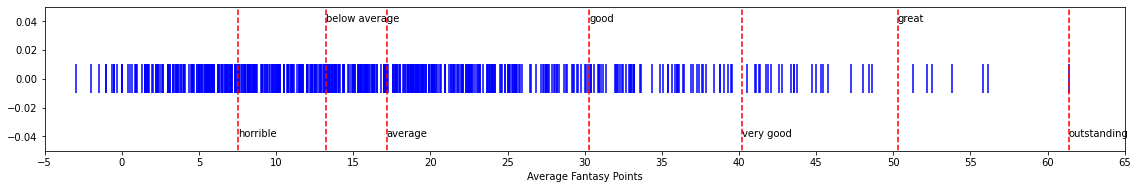

In [172]:
centres = [i[0] for i in model.cluster_centers_]
centres = sorted(centres)
plot_fp_distribution(fps["Fantasy Points"],centres,labs.values())